# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time
import pandas as pd
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Upload the `test.csv` and `training.csv` files that you can download from campus virtual.

In [6]:
# loading data

FTRAIN = '/content/drive/MyDrive/MASTER/Deep Learning /training.csv'
FTEST = '/content/drive/MyDrive/MASTER/Deep Learning /test.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns #if cols != none
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)



Number of samples in /content/drive/MyDrive/MASTER/Deep Learning /training.csv : 2140
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

 Sample image with labels:


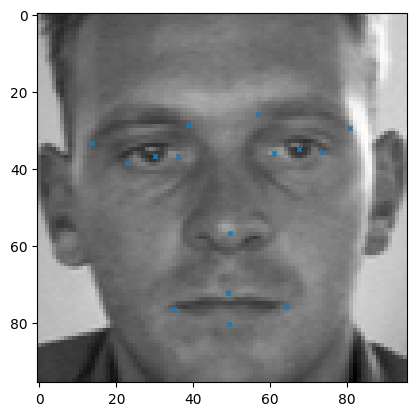

In [7]:
# loading data
X, y = load()
print("\n Sample image with labels:")
plot_sample(X[13],y[13])

In [8]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


In [11]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [



        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),



    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 30)                1

In [12]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 12s 149ms/step - loss: 0.3127 - val_loss: 0.1924
Epoch 2/50
11/11 [==============================] - 0s 42ms/step - loss: 0.1392 - val_loss: 0.1290
Epoch 3/50
11/11 [==============================] - 0s 41ms/step - loss: 0.1012 - val_loss: 0.0869
Epoch 4/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0778 - val_loss: 0.0776
Epoch 5/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0652 - val_loss: 0.0661
Epoch 6/50
11/11 [==============================] - 0s 44ms/step - loss: 0.0581 - val_loss: 0.0615
Epoch 7/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0512 - val_loss: 0.0565
Epoch 8/50
11/11 [==============================] - 0s 44ms/step - loss: 0.0458 - val_loss: 0.0545
Epoch 9/50
11/11 [==============================] - 1s 47ms/step - loss: 0.0428 - val_loss: 0.0516
Epoch 10/50
11/11 [==============================] - 1s 46ms/step - loss: 0.0396 - val_loss: 0.0484
Epoch 1

In [13]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 9ms/step
Mean pixel error:  2.0025861


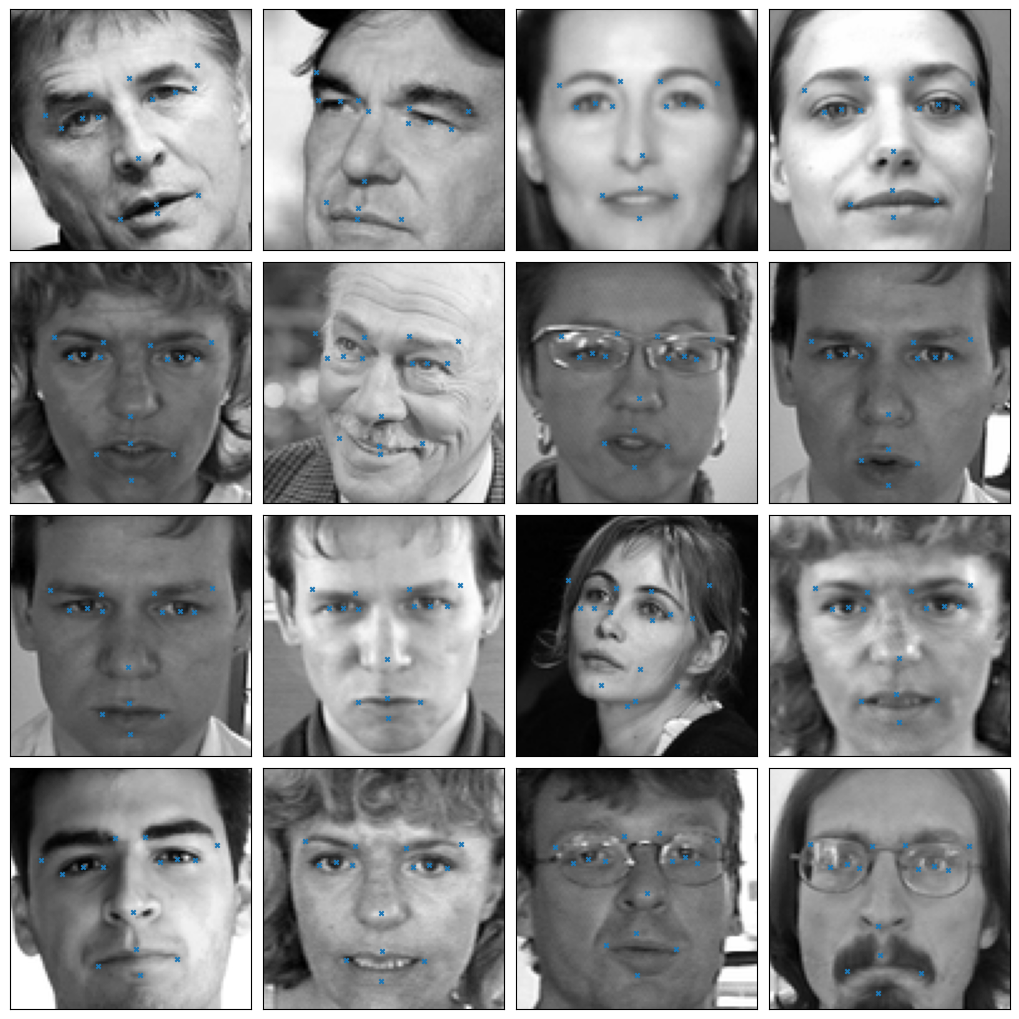

In [14]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

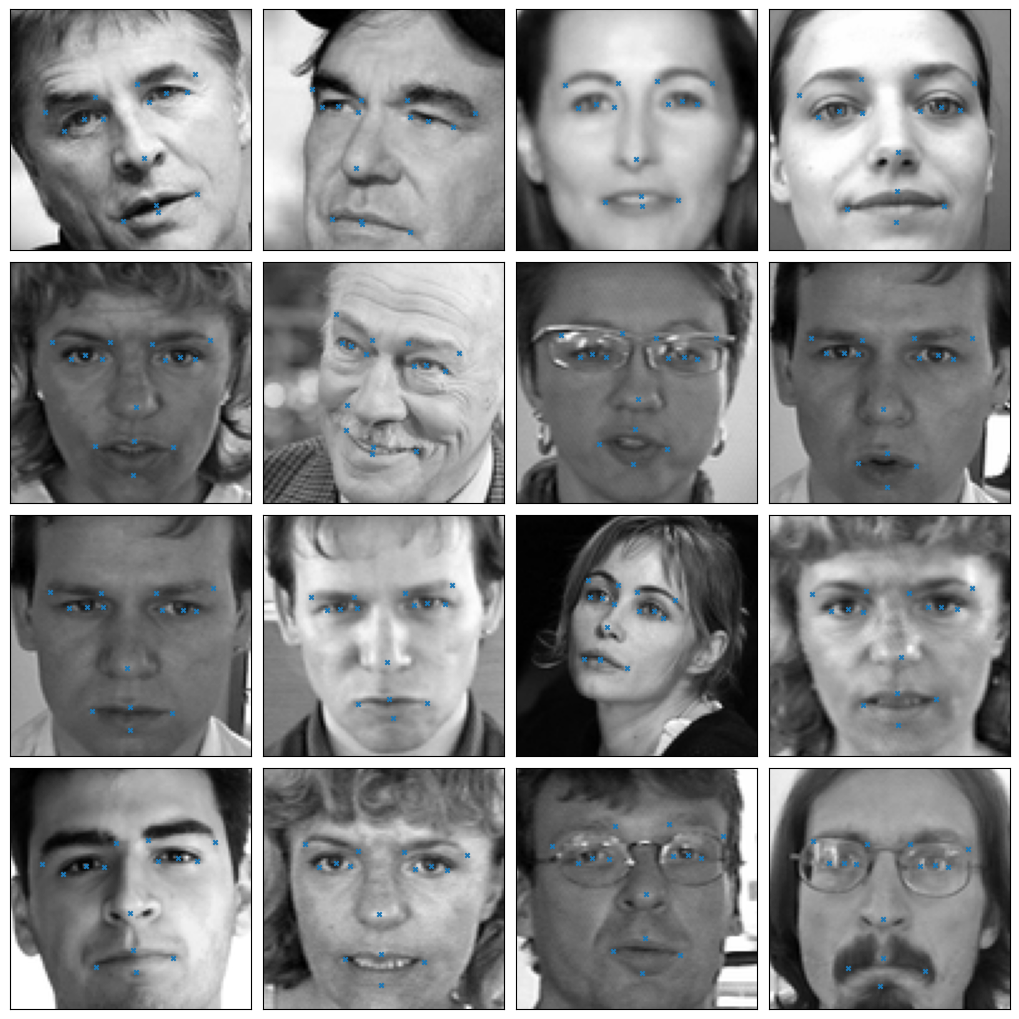

In [15]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Your solution

Let's do some data augmentation


In [16]:
#Let us change the greylevel image. In order to do that we can make the image darker and brighter.
def brighter(X, scale_factor=1.5):
  bright = X * scale_factor
  return(np.clip(bright, 0, 1) )

def darker(X, reduction_factor=0.2):
  dark = X - reduction_factor
  return(np.clip(dark, 0, 1))

#Flip the image horizontally
def flip(X,y):
  flipped_im = np.copy(X)[:,:,::-1,:]
  flipped_keypoints = np.zeros(y.shape)
  for i in range(X.shape[0]):  #flipping keypoints
    flipped_keypoints[i,:] = y[i,:]
    flipped_keypoints[i,0::2] *= -1
    flip_indices = [(0, 2), (1, 3),(4, 8), (5, 9), (6, 10), (7, 11),(12, 16), (13, 17), (14, 18), (15, 19),(22, 24), (23, 25)]
    for j,k in flip_indices:
      aux = flipped_keypoints[i,j]
      flipped_keypoints[i,j] = flipped_keypoints[i,k]
      flipped_keypoints[i,k] = aux
  return(flipped_im, flipped_keypoints)

def sharpen(X):
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharp = np.zeros(X.shape)
    for i in range(X.shape[0]):
        # Apply the kernel to each channel separately
        for channel in range(X.shape[-1]):
            sharp[i, :, :, channel] = cv2.filter2D(X[i, :, :, channel], -1, kernel)
    return(sharp)

#Blur the image
from scipy.ndimage import gaussian_filter
def blurred_image(X):
  blurred_im = np.zeros(X.shape)
  for i in range(X.shape[0]):
    blurred_im[i,:,:,:] = gaussian_filter(X[i,:,:,:], sigma=1.5)
  return(blurred_im)

#Adding noise
def noise(X, noise_level=0.05):
  noise_mask = np.random.rand(*X.shape) > (1 - noise_level)
  return(np.clip(X + noise_mask, 0, 1))



Let us see how our functions work

The original image:

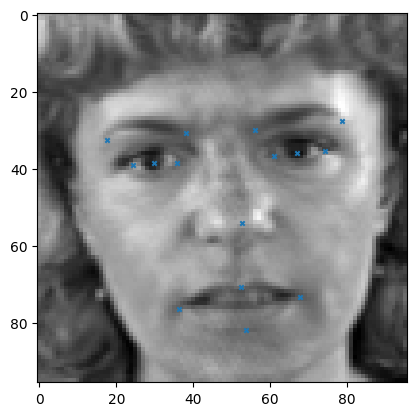

In [17]:
plot_sample(x_train[12],y_train[12])

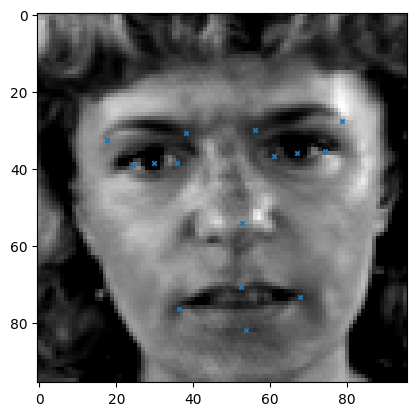

In [18]:
#Darker
dark = darker(x_train)
plot_sample(dark[12],y_train[12])

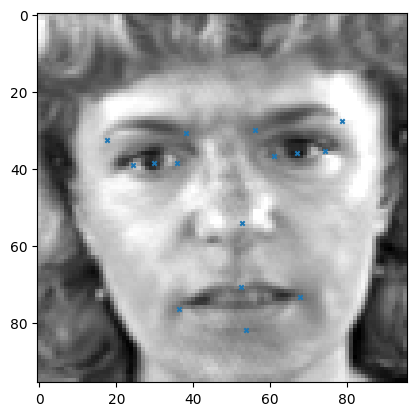

In [19]:
#Brighter
bright = brighter(x_train)
plot_sample(bright[12],y_train[12])

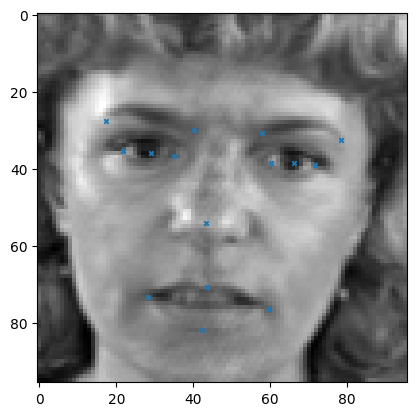

In [20]:
#Flip the image horizontally
flipped_h, y_flip = flip(x_train,y_train)
plot_sample(flipped_h[12],y_flip[12])

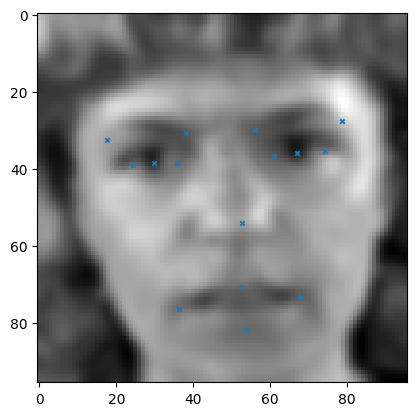

In [21]:
#Blur
blur = blurred_image(x_train)
plot_sample(blur[12],y_train[12])

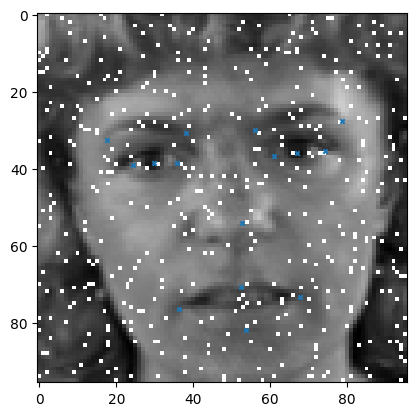

In [22]:
noised = noise(x_train)
plot_sample(noised[12],y_train[12])


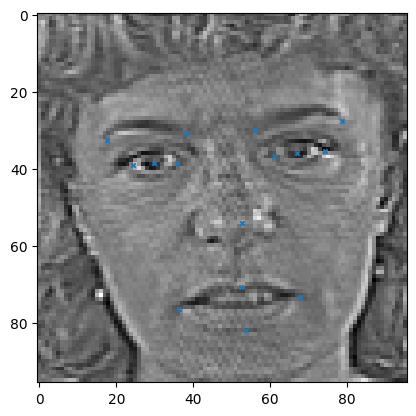

In [23]:
sharp = sharpen(x_train)
plot_sample(sharp[12],y_train[12])

In [24]:
#Let's join all the data that we have created
augmented_X = np.concatenate((x_train,  flipped_h,  blur,  sharp, dark,  bright,  noised))
augmented_y = np.concatenate((y_train,  y_flip,  y_train,  y_train,  y_train, y_train, y_train))
#Note that now the dimension has augmented
print(augmented_X.shape)

(10486, 96, 96, 1)


In [25]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [



        keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.10),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.10),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.10),

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.10),

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),



        layers.Flatten(),
        layers.Dropout(0.20),
        layers.Dense(output_shape, activation="linear"),



    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)       

In [ ]:
batch_size = 256
epochs = 300

from keras import backend as K
from keras.callbacks import EarlyStopping

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred*48 - y_true*48)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

#model.fit(augmented_X, augmented_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
#callback = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')]
model.fit(augmented_X, augmented_y,batch_size=batch_size, epochs=epochs, validation_data=(x_valid,y_valid), shuffle = True)


Epoch 1/300
41/41 [==============================] - 6s 98ms/step - loss: 6.3156 - val_loss: 4.3223
Epoch 2/300
41/41 [==============================] - 4s 90ms/step - loss: 3.5360 - val_loss: 3.6285
Epoch 3/300
41/41 [==============================] - 4s 89ms/step - loss: 3.4122 - val_loss: 3.6679
Epoch 4/300
41/41 [==============================] - 4s 89ms/step - loss: 3.3249 - val_loss: 3.0819
Epoch 5/300
41/41 [==============================] - 4s 92ms/step - loss: 3.2463 - val_loss: 3.0213
Epoch 6/300
41/41 [==============================] - 4s 92ms/step - loss: 3.0855 - val_loss: 2.7273
Epoch 7/300
41/41 [==============================] - 4s 90ms/step - loss: 2.8072 - val_loss: 2.6982
Epoch 8/300
41/41 [==============================] - 4s 91ms/step - loss: 2.5425 - val_loss: 2.1896
Epoch 9/300
41/41 [==============================] - 4s 91ms/step - loss: 2.3827 - val_loss: 2.0107
Epoch 10/300
41/41 [==============================] - 4s 93ms/step - loss: 2.2511 - val_loss: 1.8354

In [ ]:
y_new = model.predict(x_test)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))
print("Mean pixel error: ", rmse_pixel(y_test, y_new))

11/11 [==============================] - 0s 4ms/step
Mean pixel error:  1.1890155


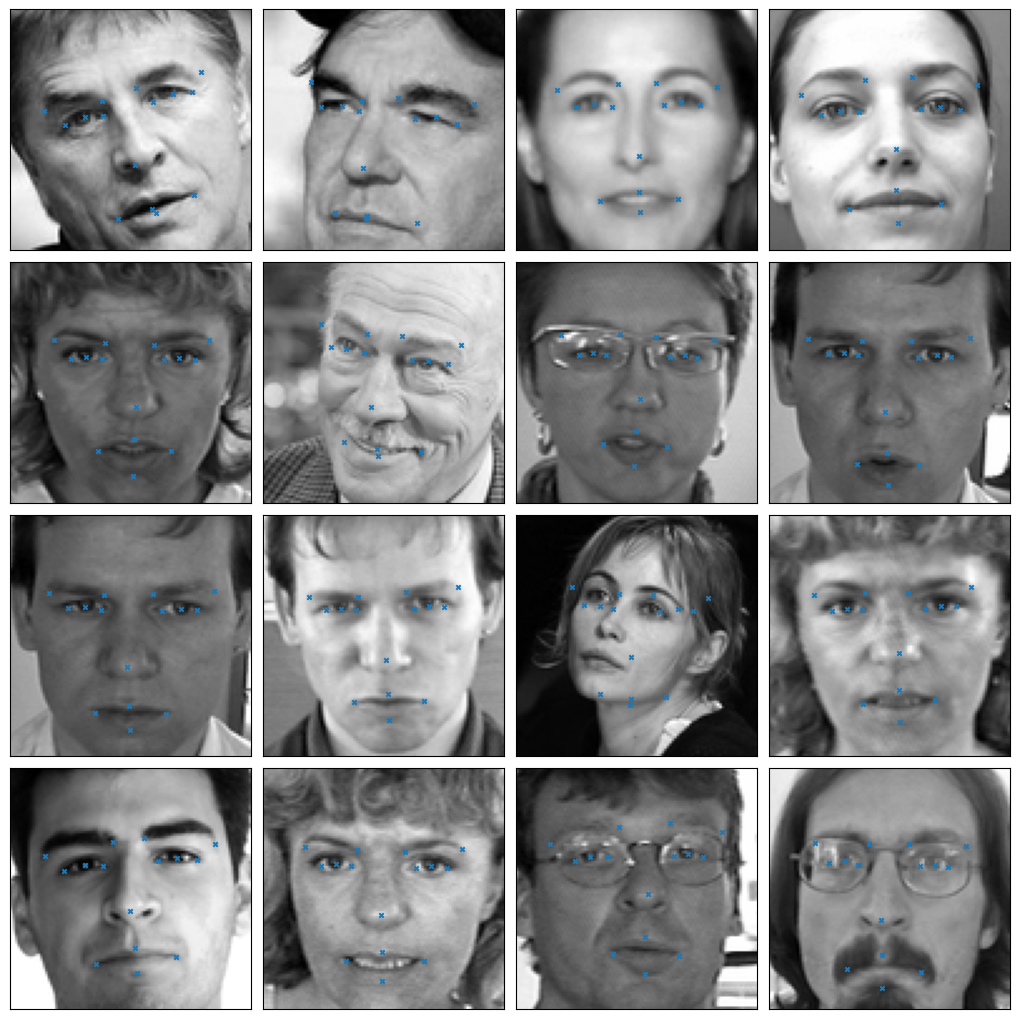

In [29]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

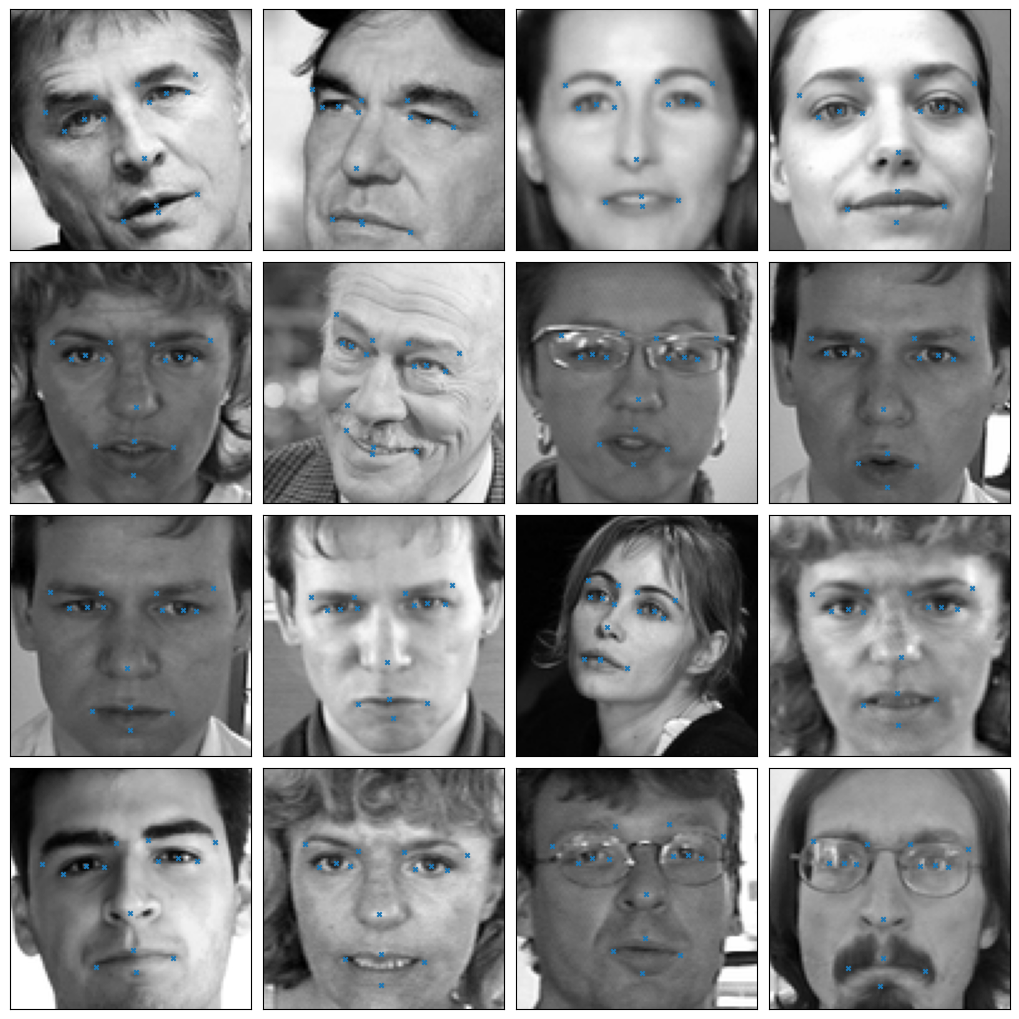

In [30]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])
pyplot.show()

We can see a very good performance!

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.3 or less, it is an outstanding result!

**Answer**: The mean pixel error is 1.1890155


## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**:



Let us describe what we have done in order to improve the mean pixel error.

First of all, we decided to do some data augmentation, that is:

1) We changed the greylevel image, making the image darker and brighter.

2) We flipped the image horizontally, not only the image, but also the labels.

3) We made the image less sharp.

4) We blurred the image.

5) Finally we added noise (white pixels).

(Note that all this data augmentation was not added at first, but it was added as we were getting different results)

Let us now focus on the model itself; the final model is composed of 5 convolutional layers, 5 max poolings and one dense layer. In order to avoid overfitting we added 5 dropout layers after the max poolings layers and one at the end before the dense layer.

About the epochs and the batch size, we decided to increase both. On the one side we augmented the train data, so it makes sense to increase the batch size. On the other hand as we were taking into account overfitting with the dropout layers, it was also reasonable to increase the epochs. It is worth mentioning that at first we were doing early stopping, but we realise that most of the times the model needed more steps to converge, and that, early stopping was not useful at all.We also tried using different optimizers (such as SGD) but we conclude that Adam was the best one with our model.

A good idea in order to continue improving the model could be reducing the epochs (and also adjusting the model), since the last losses are all near 1,20...






